In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
#import keras
import matplotlib.pyplot as plt

from subprocess import check_output
print(check_output(["ls", "../Data"]).decode("utf8"))


data_dictionary.txt
macro.csv
macro.xlsx
sample_submission.csv
test.csv
train.csv
train.xlsx



In [2]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable

In [3]:
import math
import datetime
from sklearn.preprocessing import LabelEncoder

In [4]:
# Загружаем данные. Индексом ставим timestamp.

In [5]:
macro = pd.read_csv('../Data/macro.csv',index_col=['timestamp'], parse_dates=['timestamp'], dayfirst=True)
train = pd.read_csv('../Data/train.csv',index_col=['timestamp'], parse_dates=['timestamp'], dayfirst=True)
test = pd.read_csv('../Data/test.csv',index_col=['timestamp'], parse_dates=['timestamp'], dayfirst=True)

In [6]:
macro.shape, train.shape, test.shape

((2484, 99), (30471, 291), (7662, 290))

In [7]:
# Обьединение macro & train, macro & test
ntrain, ntest = pd.concat([train,macro],axis=1,join='inner'), pd.concat([test,macro],axis=1,join='inner')

print('macro=',macro.index.min(),macro.index.max())
print('train=',train.index.min(),train.index.max())
print('test =',test.index.min(),test.index.max())
print 'macro=', macro.shape, 'ntrain=', ntrain.shape, 'ntest=', ntest.shape

('macro=', Timestamp('2010-01-01 00:00:00'), Timestamp('2016-10-19 00:00:00'))
('train=', Timestamp('2011-08-20 00:00:00'), Timestamp('2015-06-30 00:00:00'))
('test =', Timestamp('2015-07-01 00:00:00'), Timestamp('2016-05-30 00:00:00'))
macro= (2484, 99) ntrain= (30471, 390) ntest= (7662, 389)


In [8]:
# Очистка данных (пока в процессе продумывания)

In [9]:
def clear_datas (data) :
    
    # clear life_sq
    data['life_sq'].dropna(0);
    
    while (data.life_sq.loc[(data.life_sq>90) & (data.life_sq>data.full_sq)].count()>0) :
        data.life_sq.loc[(data.life_sq>90) & (data.life_sq>data.full_sq)] /= 10.0;

    iid = data[data.life_sq>data.full_sq].index
    data.ix[iid,'life_sq'] = data.ix[iid,'full_sq'];
    
    data.loc[(data.kitch_sq>1000)|(data.kitch_sq>data.life_sq)] = np.NAN
    
    return

In [10]:
# Убираем индекс, переходим на нумерацию для простоты
ntrain = ntrain.reset_index()
ntest  = ntest.reset_index()
dict_col_le = {}

In [11]:
# Сериализация символьных значений

In [12]:
for cc in ntrain.select_dtypes(exclude=['int64', 'float64','datetime64']).columns :
    
    # Добиваем пустоты в колонке
    ntrain[cc] = ntrain[cc].fillna('NANA')
    ntest[cc]  = ntest[cc].fillna('NANA')
    
    le = LabelEncoder()
    # Заполняем класс значениями
    le.fit(list(ntrain[cc].values.astype('str')) + list(ntest[cc].values.astype('str')))
    # Перегоняем и сохраняем в словаре для будущего
    ntrain[cc] = le.transform(list(ntrain[cc].values.astype('str')))
    ntest[cc]  = le.transform(list(ntest[cc].values.astype('str')))
    
    #print(cc,le.classes_)
    dict_col_le[cc] = le
    
# Добиваем пустоты
ntrain=ntrain.fillna(0)
ntest =ntest.fillna(0)    

In [13]:
dict_col_le.keys()
#ntrain.child_on_acc_pre_school.unique()
#ntest.child_on_acc_pre_school.unique()
#dict_col_le['sub_area'].inverse_transform(ntrain.sub_area.unique())

['railroad_terminal_raion',
 'oil_chemistry_raion',
 'culture_objects_top_25',
 'product_type',
 'sub_area',
 'modern_education_share',
 'incineration_raion',
 'detention_facility_raion',
 'thermal_power_plant_raion',
 'radiation_raion',
 'old_education_build_share',
 'railroad_1line',
 'ecology',
 'big_market_raion',
 'water_1line',
 'nuclear_reactor_raion',
 'big_road1_1line',
 'child_on_acc_pre_school']

In [14]:
# Дополнение train полями usd, eur и расчет дополнительных результативных полей в train (стоимость м2 в usd и eur для жилой и общей площади)

In [15]:
def add_datetime (data) :
    data['day']     = data.timestamp.dt.day  
    data['month']   = data.timestamp.dt.month
    data['year']    = data.timestamp.dt.year
    data['week']    = data.timestamp.dt.week
    data['weekday'] = data.timestamp.dt.weekday
    return

def add_features_1 (data) :
    
    #data = data.reset_index()
    
    data['build_year0']   = data.build_year; 
    data.build_year0.loc[data.build_year<=1000]=data.year.loc[data.build_year<=1000]-1;
    
    data['full0']         = data.full_sq; data.full0.loc[data.full_sq==0]=1.0
    data['life0']         = data.life_sq; data.life0.loc[data.life_sq==0]=data.full0.loc[data.life_sq==0]; 
    data.life0.loc[data.life_sq>data.full_sq] = data.full0.loc[data.life_sq>data.full_sq]
    
    data['floor0']        = data.floor;     data.floor0.loc[data.floor<1]=1.0;
    data['max_floor0']    = data.max_floor; 
    data.max_floor0.loc[data.max_floor0<data.floor0]=data.floor0.loc[data.max_floor0<data.floor0];
    
    data.kitch_sq.loc[data.kitch_sq>data.life0] = data.life0.loc[data.kitch_sq>data.life0]
    
    data.num_room.loc[data.num_room<1] = 1
    
    data['floor:max']     = data.floor0/data.max_floor0  
    data['max-floor']     = data.max_floor0-data.floor0
    data['kitch:full']    = data.kitch_sq/data.full0 #/data.kitch_sq.median()
    data['life:full']     = data.life0/data.full0
    data['full:room']     = data.full0/data.num_room #/data.full0.median()
    data['life:room']     = data.life0/data.num_room
    data['full-life']     = data.full0-data.life0
    data['build-year']    = data.build_year0-data.year
    
    #data = data.set_index('timestamp')
    
    return(data)


In [129]:
ttrain, ttest = ntrain.copy(), ntest.copy();

add_datetime(ttrain)
add_datetime(ttest)

add_features_1(ttrain)
add_features_1(ttest)

ttrain['usd']=ttrain.price_doc/ttrain.usdrub; 
ttrain['eur']=ttrain.price_doc/ttrain.eurrub

ttrain['usdm2full'] = ttrain.usd/(ttrain.full0)
ttrain['usdm2life'] = ttrain.usd/(ttrain.life0)

ttrain['eurm2full'] = ttrain.eur/(ttrain.full0)
ttrain['eurm2life'] = ttrain.eur/(ttrain.life0)

#ttrain['full_life'], ttest['full_life'] = (ttrain.full_sq+1)/(ttrain.life_sq+1), (ttest.full_sq+1)/(ttest.life_sq+1)

ttrain['div_eurrub'],  ttest['div_eurrub']  = 1/ttrain.eurrub, 1/ttest.eurrub
ttrain['div_usdrub'],  ttest['div_usdrub']  = 1/ttrain.usdrub, 1/ttest.usdrub
ttrain['div_eurrub2'], ttest['div_eurrub2'] = ttrain.div_eurrub**2, ttest.div_eurrub**2
ttrain['div_usdrub2'], ttest['div_usdrub2'] = ttrain.div_usdrub**2, ttest.div_usdrub**2

coef = 0.956

###ttrain['r']    = np.log1p(ttrain.price_doc) # 2017-05-31 LB = 0.86
###ttrain['r']    = np.log1p(ttrain.usdm2full) # 2017-06-02 LB = 0.51
###ttrain['r']    = ttrain.usdm2full # 2017-06-02 LB = 0.361
###ttrain['r'] = ttrain.price_doc/(ttrain.full_sq+1.0) # # 2017-06-02 LB = 0.41066
##ttrain['r'] = ttrain.usdm2life # # 2017-06-02 LB = 0.37543
#######################################################################################################
ttrain['r'] = ttrain.usdm2full*coef 

llist = range(5,15)+range(25,35)+range(55,65)+range(85,95)+range(115,125)+range(145,155)+range(175,185)
xxrain = (pd.concat([macro.usdrub.shift(i) for i in llist], axis=1,keys=['L%s' % i for i in llist])).dropna()

ttrain = ttrain.set_index('timestamp')
ttest  = ttest.set_index('timestamp')

ttrain = pd.concat([ttrain,xxrain],axis=1,join='inner')
ttest  = pd.concat([ttest,xxrain], axis=1,join='inner')

ttrain = ttrain.reset_index()
ttest  = ttest.reset_index()

print(train.shape,ttrain.shape,test.shape,ttest.shape,xxrain.shape) #,llist)
ttrain.head()

((30471, 291), (30471, 490), (7662, 290), (7662, 482), (2297, 70))


,timestamp,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,L175,L176,L177,L178,L179,L180,L181,L182,L183,L184
0,2011-08-20,1,43,27.0,4.0,0.0,0.0,0.0,1.0,0.0,...,28.8913,28.8913,28.9957,29.1769,29.2807,29.1615,29.1666,29.1666,29.1666,29.2670
1,2011-08-23,2,34,19.0,3.0,0.0,0.0,0.0,1.0,0.0,...,28.7238,28.8705,28.8913,28.8913,28.8913,28.9957,29.1769,29.2807,29.1615,29.1666
2,2011-08-27,3,43,29.0,2.0,0.0,0.0,0.0,1.0,0.0,...,28.1741,28.1741,28.2145,28.3870,28.7238,28.8705,28.8913,28.8913,28.8913,28.9957
3,2011-09-01,4,89,50.0,9.0,0.0,0.0,0.0,1.0,0.0,...,28.5456,28.3738,28.2550,28.2416,28.1741,28.1741,28.1741,28.2145,28.3870,28.7238
4,2011-09-05,5,77,77.0,4.0,0.0,0.0,0.0,1.0,0.0,...,28.5080,28.6150,28.6150,28.6150,28.5456,28.3738,28.2550,28.2416,28.1741,28.1741


In [130]:
# Начинаем строить модель по остаткам train данных

In [131]:
col_res     = ['r'];
col_notuse  = ['usdm2full','usdm2life','eurm2full','eurm2life','price_doc','id','eur','usd','timestamp']+col_res
##col_notuse += ['full_sq', 'life_sq', 'floor', 'max_floor', 'build_year']
##col_notuse += ['build_year0','max_floor0', 'full0'] #, 'life0']  #, 'floor0']
##col_notuse += ['usdrub','eurrub']
col_notuse += [ntrain.columns[i] for i in range(0,len(ntrain.columns)) if ntrain.dtypes[i]=='O']
col_notuse += [ntrain.columns[i] for i in range(0,len(ntrain.columns)) if len(ntrain[ntrain.columns[i]].unique())<=1]

col_use    = [ x for x in ttrain.columns.tolist() if x not in col_notuse];

train_x = ttrain[col_use+col_res]
#train_x['r']    = np.log1p(train_x.price_doc)

train_x = train_x.dropna()
train_y = train_x[col_res]
train_x = train_x[col_use]

#temp=ttrain.sub_area.value_counts()
#temp = pd.DataFrame(temp).reset_index()['index'][30:].values.tolist()
#train_y = train_y[train_x.sub_area.isin(temp)]
#train_x = train_x[train_x.sub_area.isin(temp)]

test_x  = ttest[col_use]

print train.shape, train_x.shape, test.shape, test_x.shape

(30471, 291) (30471, 480) (7662, 290) (7662, 480)


In [132]:
#ttrain[ttrain.life_sq!=ttrain.life0][['full_sq','life_sq','full0','life0','price_doc']]
#ttrain.life_sq.ptp()
#ttrain[]['floor','max_floor']
#ttrain[ttrain.max_floor0<ttrain.floor0][['floor','max_floor']].describe()
#ttrain[ttrain.max_floor0<ttrain.floor0][['floor','max_floor','floor0','max_floor0']].head()
#ttrain[ttrain.max_floor0<1][['floor','max_floor','floor0','max_floor0']].head()
#ttrain[0:10].life_sq.rank()
#pd.Series([0,0,0,0,1,1,1,1,1]).rank()
#ttrain[ttrain.build_year<1000][['build_year','year','build_year0']].describe()

In [133]:
#import xgboost as xgb
#gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05).fit(train_x, train_y.ravel())

In [134]:
print len(train),len(train_x)

30471 30471


In [135]:
import math
import xgboost as xgb

def rmsle(preds, dtrain):
    labels = dtrain.get_label()
    assert len(preds) == len(labels)
    preds_ = np.abs(preds)
    logs   = np.log1p(labels)-np.log1p(preds_)
    logs2  = np.sqrt((logs*logs).mean())
    return 'rmsle', logs2

def xgbtrain (param, train_x, train_y, num_round=1800, stopping=10, ratio=0.9) :
    
    split = int(round(ratio*len(train_y)))
    dtrain = xgb.DMatrix(train_x[:split],label=train_y[:split])
    dvalid = xgb.DMatrix(train_x[split:],label=train_y[split:])
    watchlist  = [(dtrain,'train'),(dvalid,'valid')]
    rvalid={}
    bst = xgb.train(param, dtrain, num_round, watchlist, evals_result=rvalid, early_stopping_rounds=stopping)
    return(bst,np.array(rvalid['valid']['rmse']))


In [136]:
# Строим основные массивы
dtrain = xgb.DMatrix(train_x,label=train_y)
dtest  = xgb.DMatrix(test_x)

In [137]:
param = {'silent':0, 'objective':'reg:linear', 'eta':0.2, 'max_depth':19, 'subsample':0.7, 'colsample_bytree':0.99, 'metrics':'rmse'}
num_round = 1800 #300 # 300-the best , 1300 не дает эффекта

print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M'))

bst, rvalid_log = xgbtrain(param, train_x, train_y, num_round=num_round, stopping=100, ratio=0.9)

train_g = bst.predict(dtrain,ntree_limit=rvalid_log.argmin())
train_g = np.abs(train_g)
_,train_rmsle = rmsle(train_g,dtrain)

train_g = bst.predict(dtrain)
train_g = np.abs(train_g)
_,train_rmsle_full = rmsle(train_g,dtrain)

print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M'), rvalid_log.argmin(), rvalid_log.min(), train_rmsle, train_rmsle_full)


2017-06-04 13:36
[0]	train-rmse:7028.98	valid-rmse:2278.5
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[1]	train-rmse:5893.69	valid-rmse:1923.87
[2]	train-rmse:5023.18	valid-rmse:1685.7
[3]	train-rmse:4472.71	valid-rmse:1473.35
[4]	train-rmse:3840.15	valid-rmse:1337.81
[5]	train-rmse:3449.39	valid-rmse:1214.67
[6]	train-rmse:3047.74	valid-rmse:1138.13
[7]	train-rmse:2719.36	valid-rmse:1067.06
[8]	train-rmse:2436.54	valid-rmse:1010.28
[9]	train-rmse:2165.53	valid-rmse:983.383
[10]	train-rmse:1951.23	valid-rmse:957.338
[11]	train-rmse:1755.39	valid-rmse:943.23
[12]	train-rmse:1668.56	valid-rmse:922.76
[13]	train-rmse:1523.82	valid-rmse:912.545
[14]	train-rmse:1421.34	valid-rmse:904.049
[15]	train-rmse:1309.1	valid-rmse:900.083
[16]	train-rmse:1257.2	valid-rmse:891.555
[17]	train-rmse:1182.03	valid-rmse:887.026
[18]	train-rmse:1138.3	valid-rmse:882.6
[19]	train-rmse:1050.69	valid-rmse:877.

In [143]:
train_s_x = train_x[train_x.sub_area.isin(range(65,75+1)+range(85,105+1)+range(130,135+1))]
train_s_y = train_y[train_x.sub_area.isin(range(65,75+1)+range(85,105+1)+range(130,135+1))]

train_s_x = train_x[train_x.state.isin(range(2,4))]
train_s_y = train_y[train_x.state.isin(range(2,4))]

param = {'silent':0, 'objective':'reg:linear', 'eta':0.01, 'max_depth':3}
bst, rvalid_log = xgbtrain(param, train_s_x, train_s_y, num_round=1000, stopping=30, ratio=0.9)

train_g = bst.predict(dtrain)
_,dtrain_rmsle = rmsle(train_g,dtrain)

strain = xgb.DMatrix(train_s_x,label=train_s_y)
train_s = bst.predict(strain)
_,strain_rmsle = rmsle(train_s,strain)

print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M'),len(train_s_y), rvalid_log.argmin(), rvalid_log.min(), train_g.min(), train_g.max(), dtrain_rmsle, strain_rmsle)


[0]	train-rmsle:4.49148	valid-rmsle:4.45272
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 20 rounds.
[1]	train-rmsle:3.82854	valid-rmsle:3.79498
[2]	train-rmsle:3.43815	valid-rmsle:3.41511
[3]	train-rmsle:3.16295	valid-rmsle:3.13864
[4]	train-rmsle:2.94999	valid-rmsle:2.92955
[5]	train-rmsle:2.77747	valid-rmsle:2.75571
[6]	train-rmsle:2.63225	valid-rmsle:2.61348
[7]	train-rmsle:2.50753	valid-rmsle:2.48754
[8]	train-rmsle:2.39813	valid-rmsle:2.38023
[9]	train-rmsle:2.30099	valid-rmsle:2.28211
[10]	train-rmsle:2.21376	valid-rmsle:2.19646
[11]	train-rmsle:2.13477	valid-rmsle:2.11652
[12]	train-rmsle:2.06261	valid-rmsle:2.04561
[13]	train-rmsle:1.99629	valid-rmsle:1.97849
[14]	train-rmsle:1.935	valid-rmsle:1.91872
[15]	train-rmsle:1.87814	valid-rmsle:1.86102
[16]	train-rmsle:1.82508	valid-rmsle:1.80941
[17]	train-rmsle:1.77527	valid-rmsle:1.76601
[18]	train-rmsle:1.72876	valid-rmsle:1.72034
[19]	train

In [132]:
math.sqrt((30471.0-11991.0)/30471*0.48**2+11991.0/30471*0.3327**2)
datetime.datetime.now().strftime('%Y-%m-%d %H:%M')
train.describe()
#test.state.unique()
#train.state.value_counts()

,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
count,30471.000000,30471.000000,24088.000000,30304.000000,20899.000000,20899.000000,1.686600e+04,20899.000000,20899.000000,16912.000000,...,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,3.047100e+04
mean,15237.917397,54.214269,34.403271,7.670803,12.558974,1.827121,3.068057e+03,1.909804,6.399301,2.107025,...,32.058318,10.783860,1.771783,15.045552,30.251518,0.442421,8.648814,52.796593,5.987070,7.123035e+06
std,8796.501536,38.031487,52.285733,5.319989,6.756550,1.481154,1.543878e+05,0.851805,28.265979,0.880148,...,73.465611,28.385679,5.418807,29.118668,47.347938,0.609269,20.580741,46.292660,4.889219,4.780111e+06
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+05
25%,7620.500000,38.000000,20.000000,3.000000,9.000000,1.000000,1.967000e+03,1.000000,1.000000,1.000000,...,2.000000,1.000000,0.000000,2.000000,9.000000,0.000000,0.000000,11.000000,1.000000,4.740002e+06
50%,15238.000000,49.000000,30.000000,6.500000,12.000000,1.000000,1.979000e+03,2.000000,6.000000,2.000000,...,8.000000,2.000000,0.000000,7.000000,16.000000,0.000000,2.000000,48.000000,5.000000,6.274411e+06
75%,22855.500000,63.000000,43.000000,11.000000,17.000000,2.000000,2.005000e+03,2.000000,9.000000,3.000000,...,21.000000,5.000000,1.000000,12.000000,28.000000,1.000000,7.000000,76.000000,10.000000,8.300000e+06
max,30473.000000,5326.000000,7478.000000,77.000000,117.000000,6.000000,2.005201e+07,19.000000,2014.000000,33.000000,...,377.000000,147.000000,30.000000,151.000000,250.000000,2.000000,106.000000,218.000000,21.000000,1.111111e+08


In [204]:
param = {'silent':'0', 'objective':'reg:linear', 'eta':0.02, 'max_depth':10}
num_round = 1800 #300 # 300-the best , 1300 не дает эффекта

rr, split_last = [],0

print (datetime.datetime.now())

#for split_new in [20,30,50,100,len(train_x.sub_area)] :
#for split_new in [25,50,70,90,len(train_x.sub_area.unique())] :
for split_new in range(5,int(train_x.sub_area.max())+1,5) :
    
    train_s_x = train_x[train_x.sub_area.isin(range(int(split_last),int(split_new+1)))]
    train_s_y = train_y[train_x.sub_area.isin(range(int(split_last),int(split_new+1)))]

    bst, rvalid_log = xgbtrain(param,train_s_x,train_s_y)
    train_g = bst.predict(dtrain)
    print(datetime.datetime.now(),split_last, split_new, len(train_s_y), rvalid_log.argmin(), rvalid_log.min(), train_g.min(), train_g.max())
    rr.append([split_last, split_new, len(train_s_y), rvalid_log.argmin(), rvalid_log.min(), train_g.min(), train_g.max()])
    split_last = split_new
    
#print np.sqrt(((np.log(np.clip(train_g,0,train_g)+1)-np.log(train_y.values+1))**2).mean())

2017-06-02 23:13:13.517158
[0]	train-rmsle:3.92842	valid-rmsle:4.22911
Multiple eval metrics have been passed: 'valid-rmsle' will be used for early stopping.

Will train until valid-rmsle hasn't improved in 20 rounds.
[1]	train-rmsle:3.241	valid-rmsle:3.54964
[2]	train-rmsle:2.83907	valid-rmsle:3.00521
[3]	train-rmsle:2.55697	valid-rmsle:2.70432
[4]	train-rmsle:2.34421	valid-rmsle:2.52043
[5]	train-rmsle:2.17363	valid-rmsle:2.31634
[6]	train-rmsle:2.03189	valid-rmsle:2.20148
[7]	train-rmsle:1.90873	valid-rmsle:2.10537
[8]	train-rmsle:1.8005	valid-rmsle:1.95891
[9]	train-rmsle:1.7052	valid-rmsle:1.84914
[10]	train-rmsle:1.62002	valid-rmsle:1.74452
[11]	train-rmsle:1.54299	valid-rmsle:1.63624
[12]	train-rmsle:1.47219	valid-rmsle:1.53988
[13]	train-rmsle:1.40842	valid-rmsle:1.47191
[14]	train-rmsle:1.35037	valid-rmsle:1.40868
[15]	train-rmsle:1.29649	valid-rmsle:1.34863
[16]	train-rmsle:1.24726	valid-rmsle:1.29878
[17]	train-rmsle:1.20108	valid-rmsle:1.25585
[18]	train-rmsle:1.15672	valid

In [205]:
for ii in rr : print ii

[0, 5, 640, 274, 0.49635800000000002, 427.69666, 12081.401]
[5, 10, 945, 425, 0.51961999999999997, 229.52989, 10759.421]
[10, 15, 1191, 170, 0.54957100000000003, 316.75485, 7137.3076]
[15, 20, 1246, 141, 0.57065200000000005, 449.70831, 198995.09]
[20, 25, 849, 151, 0.75849699999999998, 261.53488, 11820.343]
[25, 30, 1087, 198, 0.50190000000000001, 706.79462, 614535.12]
[30, 35, 1154, 184, 0.46602399999999999, 616.81488, 602978.81]
[35, 40, 1208, 221, 0.57780799999999999, 393.56015, 11680.995]
[40, 45, 1014, 141, 0.59879800000000005, 451.50348, 7749.8374]
[45, 50, 1226, 270, 0.55420400000000003, 376.20383, 9930.4365]
[50, 55, 846, 367, 0.54253200000000001, 355.76801, 356213.69]
[55, 60, 1371, 200, 0.49113800000000002, 378.98029, 13598.32]
[60, 65, 1535, 197, 0.48666199999999998, 311.78806, 271376.5]
[65, 70, 1463, 171, 0.27464100000000002, 497.04465, 297258.44]
[70, 75, 2670, 205, 0.23500599999999999, 379.76648, 305796.97]
[75, 80, 1194, 306, 0.47662300000000002, 258.436, 11435.91]
[80,

In [89]:
dict_col_le['sub_area'].inverse_transform(range(65,75)+range(85,105))

array(['Mitino', 'Molzhaninovskoe', "Moskvorech'e-Saburovo", 'Mozhajskoe',
       'Nagatino-Sadovniki', 'Nagatinskij Zaton', 'Nagornoe', 'Nekrasovka',
       'Nizhegorodskoe', 'Novo-Peredelkino', 'Pokrovskoe Streshnevo',
       'Poselenie Desjonovskoe', 'Poselenie Filimonkovskoe',
       'Poselenie Kievskij', 'Poselenie Klenovskoe',
       'Poselenie Kokoshkino', 'Poselenie Krasnopahorskoe',
       'Poselenie Marushkinskoe', 'Poselenie Mihajlovo-Jarcevskoe',
       'Poselenie Moskovskij', 'Poselenie Mosrentgen',
       'Poselenie Novofedorovskoe', 'Poselenie Pervomajskoe',
       'Poselenie Rjazanovskoe', 'Poselenie Rogovskoe',
       'Poselenie Shhapovskoe', 'Poselenie Shherbinka',
       'Poselenie Sosenskoe', 'Poselenie Vnukovskoe',
       'Poselenie Voronovskoe'], 
      dtype='|S30')

In [140]:
# Строим результат

In [147]:
dtest = xgb.DMatrix(test_x)
#test_p = bst.predict(dtest,ntree_limit=rvalid_log.argmin())
test_p = bst.predict(dtest)
test_p = np.abs(test_p)

In [148]:
test_r = pd.DataFrame(ttest[['id']]); 
##test_r['price_doc']=np.expm1(test_p)*(test_x.full_sq+1)*test_x.usdrub # 2017-06-02 LB = 0.54
##test_r['price_doc'] = test_p*(test_x.full_sq+1)*test_x.usdrub; # 2017-06-02 LB = 0.361
##test_r['price_doc'] = test_p*(test_x.full_sq+1); # 2017-06-02 LB = 0.41066
##test_r['price_doc'] = test_p*(test_x.life_sq+1)*test_x.usdrub; # 2017-06-02 LB = 0.39

#test_r['price_doc'] = test_p*test_x.life0*test_x.usdrub; # 2017-06-02 LB = 0.37543
test_r['price_doc'] = test_p*ttest.full0*ttest.usdrub; # 2017-06-02 LB = 0.37296

print test_r.price_doc.min(),test_r.price_doc.max(),train.price_doc.min(),train.price_doc.max() 
test_r.head(8)
#test_r.tail(8)
#test_r.shape

41466.7127943 129545867.48 100000 111111112


,id,price_doc
0,30474,3.820832e+06
1,30475,8.219334e+06
2,30476,4.141121e+06
3,30477,6.703724e+06
4,30478,5.299270e+06
5,30479,8.856204e+06
6,30480,5.025235e+06
7,30481,4.482033e+06


In [149]:
ntest[test_r.price_doc<0.0]

,timestamp,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm


In [150]:
# Результат в файл

In [151]:
test_r[['id','price_doc']].to_csv('../Result/res-31.csv',index=False)

In [433]:
#history[:20]
xgb.__version__
#bst.__dict__

'0.6'

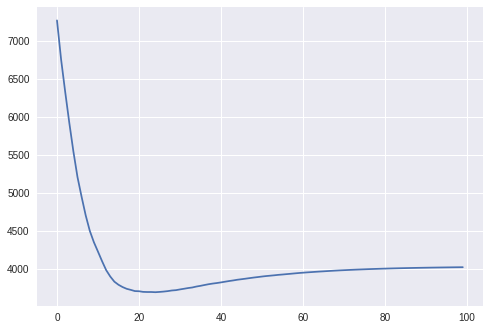

(3691.1898191999999, 24)


In [434]:
plt.plot(history['test-rmse-mean']); plt.show()
print(history['test-rmse-mean'].min(),history['test-rmse-mean'].argmin())

In [139]:
#d = dict(zip(train_x.columns, bst.feature_importances_))
#ss = sorted(d, key=d.get, reverse=True)
fff = bst.get_fscore()
#fff.keys()
fff = pd.DataFrame(fff.values(),index=fff.keys(),columns=['imp'])
ffs = fff.sort_values('imp')
ffs.tail(60)
#ffs.head(100)

,imp
big_road2_km,659
metro_min_walk,673
bus_terminal_avto_km,673
swim_pool_km,692
balance_trade,700
max_floor0,706
incineration_km,731
full-life,751
railroad_km,763
indust_part,763


In [83]:
print train_x.floor0.head(), '\n\n', len(ffs), len(train_x.columns)
ffs['imp'][['material','sub_area','life0','floor','floor0','max_floor0','max-floor','floor:max','max_floor','full0']]

timestamp
2011-08-20    4.0
2011-08-23    3.0
2011-08-27    2.0
2011-09-01    9.0
2011-09-05    4.0
Name: floor0, dtype: float64 

390 474


material       2431.0
sub_area       4460.0
life0          2637.0
floor         18546.0
floor0            NaN
max_floor0        NaN
max-floor      1537.0
floor:max      3558.0
max_floor      5971.0
full0             NaN
Name: imp, dtype: float64

In [103]:
ttrain[ttrain.max_floor0<ttrain.floor0][['floor','max_floor','floor0','max_floor0']].head()
#ttrain[ttrain.max_floor0<1][['floor','max_floor','floor0','max_floor0']].head()
#ttrain[0:10].life_sq.rank()
#pd.Series([0,0,0,0,1,1,1,1,1]).rank()
ttrain[['material']].describe()
pd.concat([pd.DataFrame(train.material.value_counts()/len(train)),pd.DataFrame(test.material.value_counts())/len(test)],axis=1)
ttrain.num_room.value_counts()
#ttrain[ttrain.kitch_sq>ttrain.life0][['kitch_sq','life0','full0']] #.count() #value_counts()
#ttrain[ttrain.num_room<1][['num_room','life0','full0']].head() #.count() #value_counts()
temp=ttrain.sub_area.value_counts()
#train.area_m.value_counts()
pd.DataFrame(temp).reset_index()['index'][:20].values.tolist()

[102.0,
 72.0,
 103.0,
 94.0,
 105.0,
 65.0,
 134.0,
 48.0,
 60.0,
 87.0,
 38.0,
 101.0,
 124.0,
 143.0,
 86.0,
 82.0,
 70.0,
 12.0,
 71.0,
 126.0]

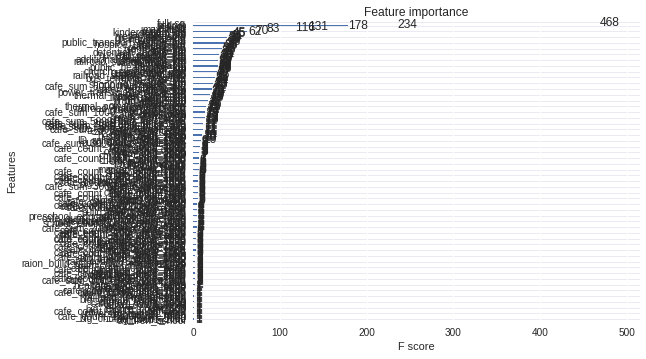

In [61]:
aax = plt.figure(figsize=(16, 16));
xgb.plot_importance(bst); 
#xgb.plot_tree(bst); 
plt.show()

In [56]:
#"+".join(col_use)
train_x.shape, train_y.values.shape
#train_x['res']=None
train_x.columns
#train_x['res']

Index([u'0_13_all', u'0_13_female', u'0_13_male', u'0_17_all', u'0_17_female',
       u'0_17_male', u'0_6_all', u'0_6_female', u'0_6_male', u'16_29_all',
       ...
       u'L176', u'L177', u'L178', u'L179', u'L180', u'L181', u'L182', u'L183',
       u'L184', u'L185'],
      dtype='object', length=445)

In [57]:

train_res    = sm.OLS(train_y,train_x)
train_res_m  = train_res.fit()

train_p = train_res_m.predict()

#train_res_m.__dict__
#train_p.shape,train_y.values.shape
#type(train_p),type(train_y.values)
print np.sqrt(((np.log(np.abs(train_p)+1)-np.log(train_y.values+1))**2).mean())
print train_res_m.summary()

ValueError: On entry to DLASCL parameter number 4 had an illegal value

In [105]:
sm.tsa.adfuller(train_y.usdm2full)

(-21.345941002557112,
 0.0,
 39,
 29319,
 {'1%': -3.4305730591978634,
  '10%': -2.5668224743616146,
  '5%': -2.8616385860519822},
 571614.25473399623)

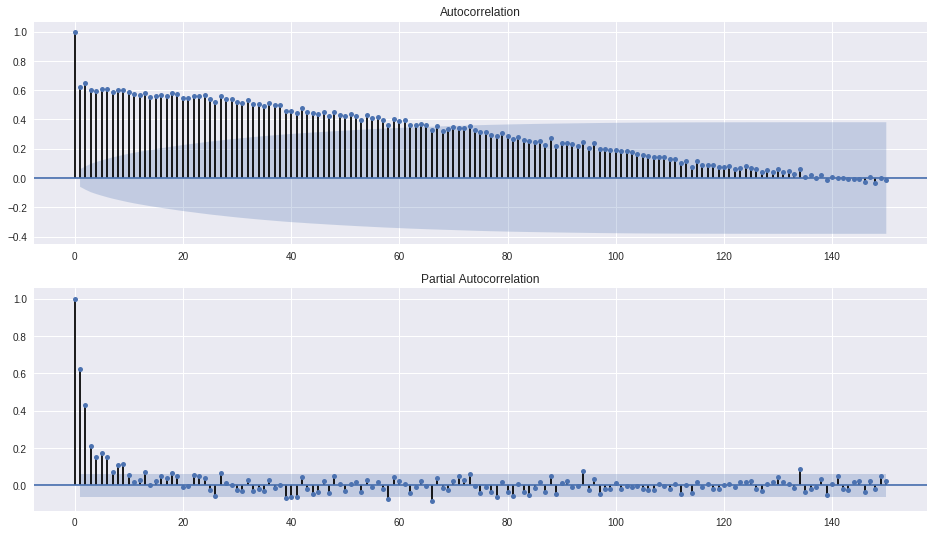

In [106]:
aax = plt.figure(figsize=(16, 9));
ax1 = aax.add_subplot(211)
sm.graphics.tsa.plot_acf(train_y.usdm2full.resample('1d').median().dropna(), lags=150, ax=ax1)
ax2 = aax.add_subplot(212)
sm.graphics.tsa.plot_pacf(train_y.usdm2full.resample('1d').median().dropna(), lags=150, ax=ax2)


In [8]:
temp=pd.DataFrame(ttrain.columns);

In [9]:
ttrain['sub_area'].unique()

array(['Bibirevo', 'Nagatinskij Zaton', "Tekstil'shhiki", 'Mitino',
       'Basmannoe', 'Nizhegorodskoe', "Sokol'niki", 'Koptevo', 'Kuncevo',
       'Kosino-Uhtomskoe', 'Zapadnoe Degunino', 'Presnenskoe', 'Lefortovo',
       "Mar'ino", "Kuz'minki", 'Nagornoe', "Gol'janovo", 'Vnukovo',
       'Juzhnoe Tushino', 'Severnoe Tushino', "Chertanovo Central'noe",
       'Fili Davydkovo', 'Otradnoe', 'Novo-Peredelkino', 'Bogorodskoe',
       'Jaroslavskoe', 'Strogino', 'Hovrino', "Moskvorech'e-Saburovo",
       'Staroe Krjukovo', 'Ljublino', 'Caricyno', 'Veshnjaki',
       'Danilovskoe', 'Preobrazhenskoe', "Kon'kovo", 'Brateevo',
       'Vostochnoe Izmajlovo', 'Vyhino-Zhulebino', 'Donskoe',
       'Novogireevo', 'Juzhnoe Butovo', 'Sokol', 'Kurkino', 'Izmajlovo',
       'Severnoe Medvedkovo', 'Rostokino', 'Orehovo-Borisovo Severnoe',
       'Ochakovo-Matveevskoe', 'Taganskoe', 'Dmitrovskoe',
       'Orehovo-Borisovo Juzhnoe', 'Teplyj Stan', 'Babushkinskoe',
       'Pokrovskoe Streshnevo', 'Obruc

In [7]:
print(' train=',train.index.min(),train.index.max())
print('ttrain=',ttrain.index.min(),ttrain.index.max())

(' train=', Timestamp('2011-08-20 00:00:00'), Timestamp('2015-06-30 00:00:00'))
('ttrain=', Timestamp('2011-08-20 00:00:00'), Timestamp('2015-06-30 00:00:00'))


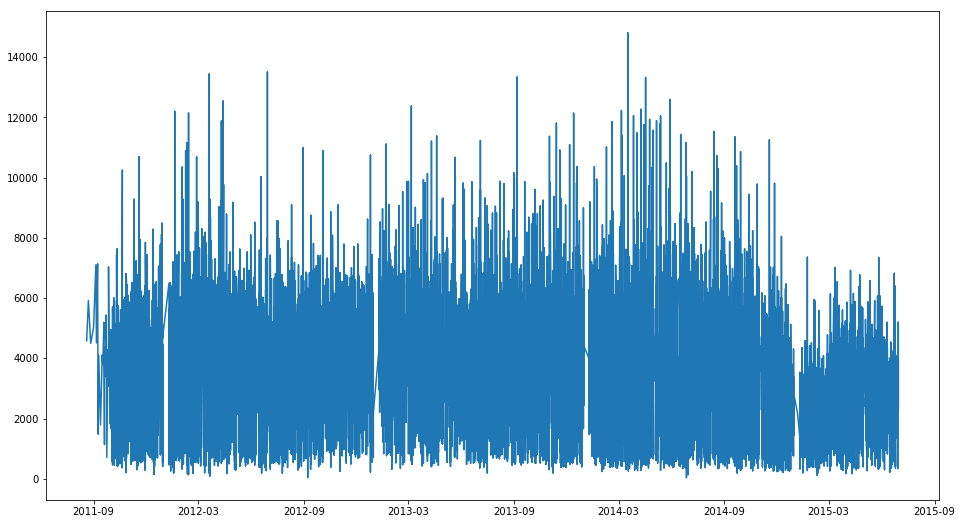

In [8]:
plt.figure(figsize=(16, 9));
plt.plot(ttrain[ttrain.usdm2full<15000].usdm2full); 
plt.show()

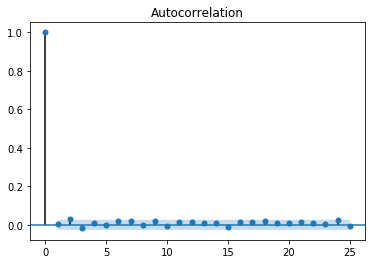

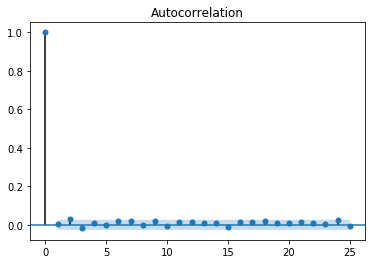

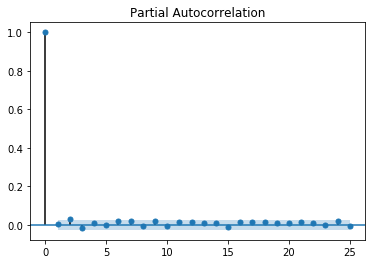

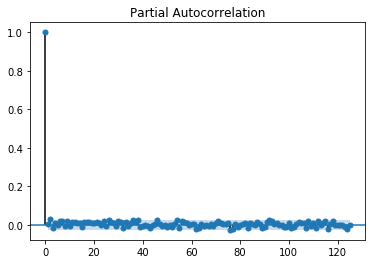

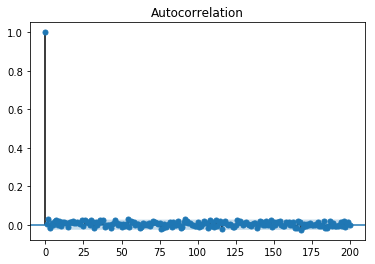

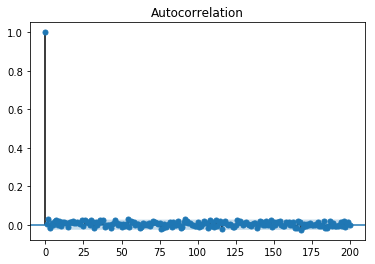

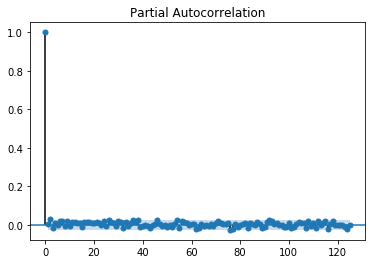

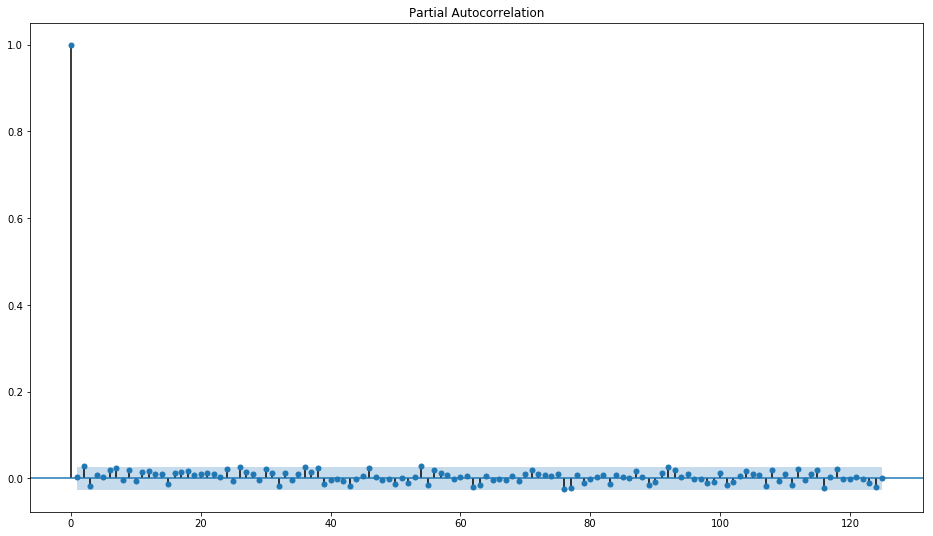

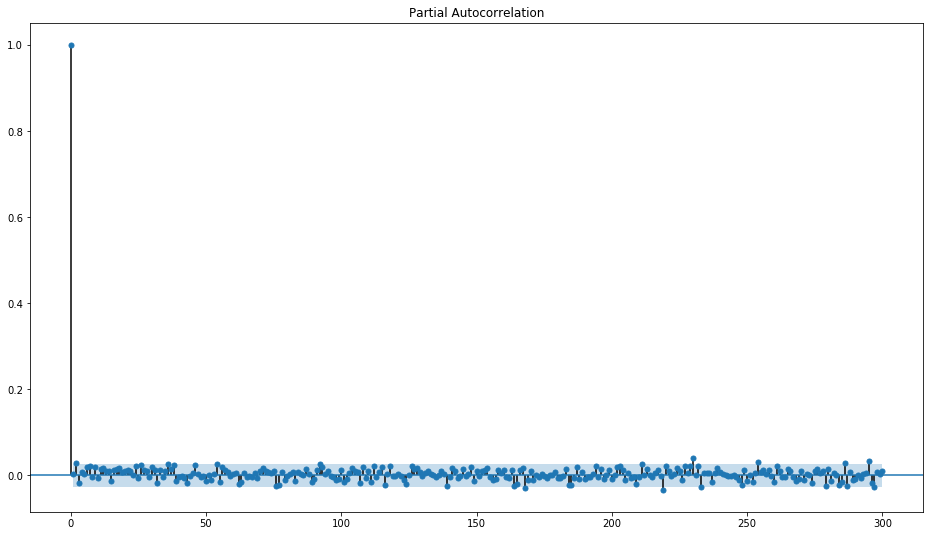

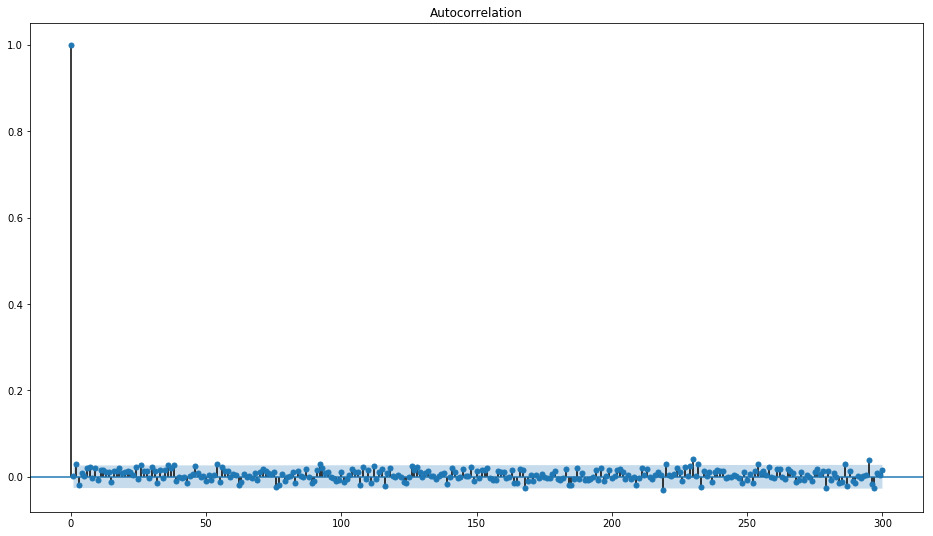

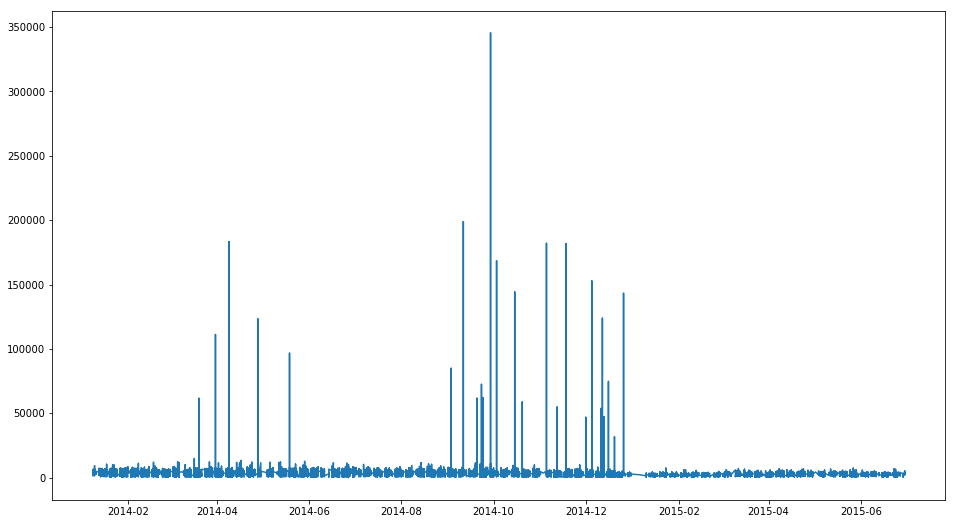

In [115]:
plt.figure(figsize=(16, 9));
xtrain = ttrain['2014-01-01':'2016-06-01'].usdm2full
#xtrain = xtrain[xtrain<15000]
#plt.plot(ttrain['01-01-2014':'01-06-2016'].usdm2full); 
plt.plot(xtrain); 
plt.show()

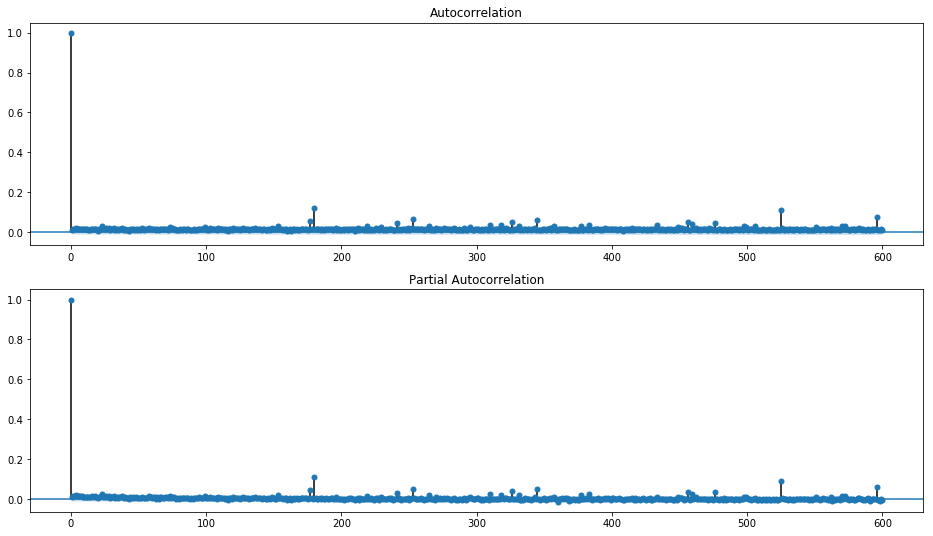

In [9]:
aax = plt.figure(figsize=(16, 9));
xtrain = ttrain.usdm2full
ax1 = aax.add_subplot(211)
sm.graphics.tsa.plot_acf(xtrain, lags=600, ax=ax1)
ax2 = aax.add_subplot(212)
sm.graphics.tsa.plot_pacf(xtrain, lags=600, ax=ax2)


In [183]:
acf,confint,qstat,pvalues = sm.tsa.stattools.acf(xtrain,nlags=600,alpha=0.05,qstat=True,fft=True)
#acf
confint.shape #[-10:]
#qstat[-10:]
#pvalues[-10:]
acf[acf>3*confint[:,0]]
#acf.shape, confint.shape
acf[177:185], confint[177:185], qstat[177:185], pvalues[177:185]

(array([ 0.05687618,  0.01495214,  0.01454301,  0.12218533,  0.01729215,
         0.01492026,  0.01349208,  0.01702206]),
 array([[ 0.04518074,  0.06857162],
        [ 0.00322188,  0.02668239],
        [ 0.00281035,  0.02627567],
        [ 0.1104504 ,  0.13392027],
        [ 0.00539791,  0.02918638],
        [ 0.00302285,  0.02681767],
        [ 0.00159232,  0.02539185],
        [ 0.00512036,  0.02892375]]),
 array([ 1404.55727916,  1411.04037485,  1868.68299746,  1877.84943322,
         1884.673916  ,  1890.25462559,  1899.13783036,  1903.71613167]),
 array([  1.93568353e-189,   3.20097876e-190,   2.63858406e-278,
          1.34856387e-279,   1.98803802e-280,   5.14158124e-281,
          2.98600922e-282,   1.21397189e-282]))

In [120]:
#sm.tsa.adfuller(ttrain[ttrain.usdm2full<15000].usdm2full)
sm.tsa.adfuller(ttrain.usdm2full)

(-21.229925707516664,
 0.0,
 39,
 30431,
 {'1%': -3.4305649075513234,
  '10%': -2.5668205567450029,
  '5%': -2.8616349833780577},
 592271.24806374311)

In [232]:
#xtrain.groupby(xtrain.timestamp).sum()
xtrain.describe()

count     30471.000000
mean       3650.223604
std        4095.528149
min          40.618140
25%        2492.251371
50%        3417.165978
75%        4645.105813
max      345512.187084
Name: usdm2full, dtype: float64

In [236]:
#xtrain.resample('1d').mean().dropna().tail()
xtrain.resample('1d').mean().dropna().tail(),xtrain.resample('1d').sum().dropna().tail()
xtrain.resample('1d').mean().dropna().describe()

count     1161.000000
mean      3708.988547
std        869.298150
min        496.223319
25%       3274.385194
50%       3777.322066
75%       4104.162062
max      10087.570228
Name: usdm2full, dtype: float64

/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: 
.resample() is now a deferred operation
You called dropna(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead
  from ipykernel import kernelapp as app


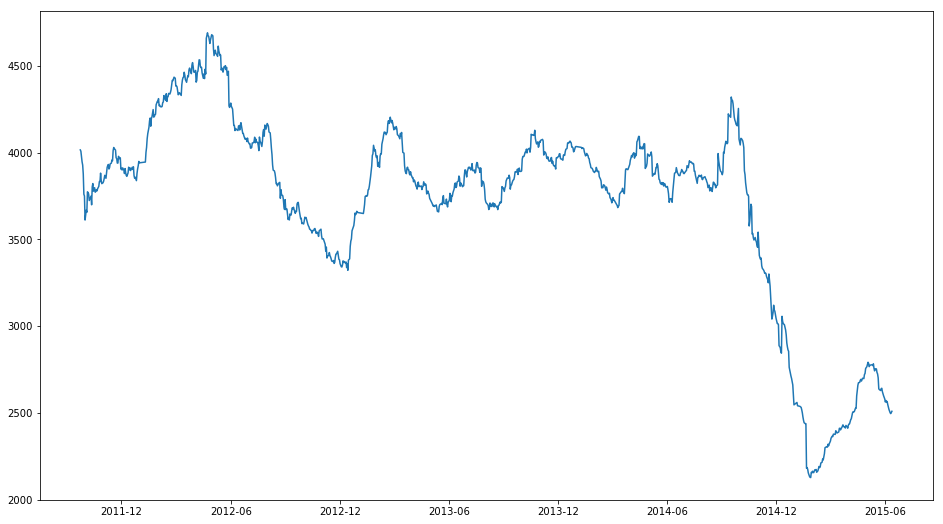

In [253]:
aax = plt.figure(figsize=(16, 9));
roll=xtrain.resample('1d').dropna().rolling(30,center=True)
plt.plot(roll.mean().dropna()); plt.show()

In [251]:
#sm.tsa.adfuller(ttrain[ttrain.usdm2full<15000].usdm2full)
sm.tsa.adfuller(xtrain.resample('1d').sum().dropna())

(-2.7249360772477709,
 0.069821741556719025,
 17,
 1143,
 {'1%': -3.4360840741163168,
  '10%': -2.5681180818615958,
  '5%': -2.864071964072552},
 27712.487722929673)

In [10]:
def tsplot(y, lags=None, figsize=(10, 8)):
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(1.5) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

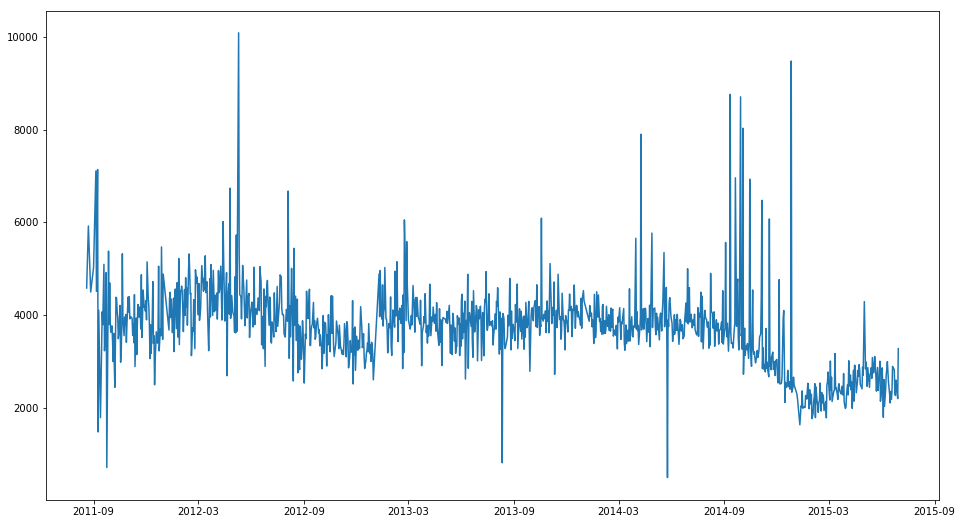

In [11]:
aax = plt.figure(figsize=(16, 9));
plt.plot(xtrain.resample('1d').mean().dropna()); plt.show()

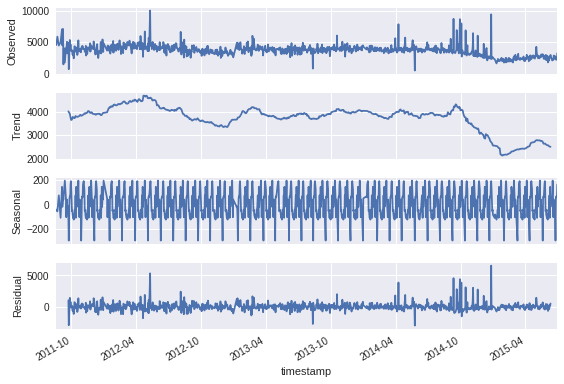

In [185]:
ytrain = pd.DataFrame(xtrain.resample('1d').mean().dropna())
smt.seasonal_decompose(ytrain,freq=30).plot()
#ytrain.head()

In [80]:
xytrain = smt.seasonal_decompose(ytrain,freq=30)
xyztrain= xytrain.resid.dropna()
#xyztrain= xytrain.trend.dropna()
xyztrain= xytrain.seasonal.dropna()
xyztrain.describe()

,usdm2full
count,201.000000
mean,3.212488
std,141.249691
min,-224.481317
25%,-106.190380
50%,-12.320971
75%,71.919435
max,413.359670


In [300]:
mod = smt.SARIMAX(ytrain, trend='c', order=(1, 1, 1))
res = mod.fit(); res.__dict__
#plt.plot(res.resid[2:]); plt.show()
#tsplot(res.resid[2:], lags=24); plt.show()

{'__doc__': '\n    Class to hold results from fitting an SARIMAX model.\n\n    Parameters\n    ----------\n    model : SARIMAX instance\n        The fitted model instance\n\n    Attributes\n    ----------\n    specification : dictionary\n        Dictionary including all attributes from the SARIMAX model instance.\n    polynomial_ar : array\n        Array containing autoregressive lag polynomial coefficients,\n        ordered from lowest degree to highest. Initialized with ones, unless\n        a coefficient is constrained to be zero (in which case it is zero).\n    polynomial_ma : array\n        Array containing moving average lag polynomial coefficients,\n        ordered from lowest degree to highest. Initialized with ones, unless\n        a coefficient is constrained to be zero (in which case it is zero).\n    polynomial_seasonal_ar : array\n        Array containing seasonal autoregressive lag polynomial coefficients,\n        ordered from lowest degree to highest. Initialized with o

In [133]:
ytrain = pd.DataFrame(xtrain.resample('1d').mean().dropna())
iin = pd.cut(ytrain['usdm2full'], 15)
iin[:5]
pd.value_counts(iin)

(3693.339, 4332.762]     473
(3053.916, 3693.339]     281
(4332.762, 4972.185]     137
(2414.493, 3053.916]     134
(1775.0696, 2414.493]     79
(4972.185, 5611.608]      30
(5611.608, 6251.0315]      8
(6890.455, 7529.878]       4
(6251.0315, 6890.455]      3
(1135.646, 1775.0696]      3
(486.632, 1135.646]        3
(9448.147, 10087.57]       2
(8169.301, 8808.724]       2
(7529.878, 8169.301]       2
(8808.724, 9448.147]       0
Name: usdm2full, dtype: int64

In [14]:
rtrain=train['sub_area'].sort_values().unique(); rtrain

rajons = pd.DataFrame(
[(rr,
  train[train['sub_area']==rr].usdm2full.mean(),
  train[train['sub_area']==rr].usdm2full.median(),
  train[train['sub_area']==rr].usdm2full.std(),
  train[train['sub_area']==rr].usdm2full.min(),
  train[train['sub_area']==rr].usdm2full.max(), 
  train[train['sub_area']==rr].usdm2full.count()) 
 for rr in rtrain  ],columns=['rajon','_mean','_median','_std','_min','_max','_count']
)

In [15]:
rajons[80:100]

,rajon,_mean,_median,_std,_min,_max,_count
80,Orehovo-Borisovo Severnoe,3535.774300,3883.312895,1277.598591,424.371801,5762.908916,206
81,Ostankinskoe,4747.442230,5153.985629,1748.818985,536.496229,8028.522145,79
82,Otradnoe,3866.539438,4329.858316,1424.168066,300.688938,6381.697822,353
83,Pechatniki,3608.515014,4036.521047,1325.991081,599.689073,5696.662812,192
84,Perovo,3632.839161,3949.543068,1399.149467,289.171396,6263.347702,247
85,Pokrovskoe Streshnevo,5553.521019,4728.396040,14029.044442,821.804444,183248.202720,164
86,Poselenie Desjonovskoe,2494.708766,2347.226417,2836.709200,505.729532,46837.005958,362
87,Poselenie Filimonkovskoe,1916.458860,1895.148411,335.460977,706.260838,3697.228693,496
88,Poselenie Kievskij,2616.911324,2616.911324,1292.771379,1702.783915,3531.038732,2
89,Poselenie Klenovskoe,701.662604,701.662604,NaN,701.662604,701.662604,1


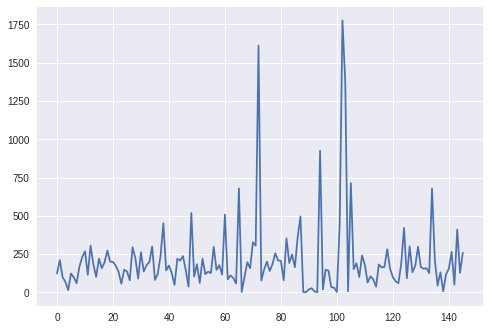

In [16]:
rajons['std/mean']=(rajons._std/rajons._mean)*100.0; rajons
plt.plot(rajons['_count']); 
plt.show()

In [17]:
len(xtrain)

NameError: name 'xtrain' is not defined

Using matplotlib backend: Qt5Agg
('Ajeroport', 0.95853208606005602, 56)
((1,), array([1]))
('------------', (0.0, 0.95853208606005602, 56, 56, {'5%': -2.9147306250000002, '1%': -3.5529282035805392, '10%': -2.5951371556122451}, -2559.3905741764333), 56)
('Akademicheskoe', 0.95853208606005602, 90)
((1,), array([1]))
('------------', (-0.0, 0.95853208606005602, 90, 90, {'5%': -2.894232085048011, '1%': -3.5051901961591221, '10%': -2.5842101234567902}, -3519.9936034586012), 90)
('Alekseevskoe', 0.95853208606005602, 46)
((1,), array([1]))
('------------', (0.0, 0.95853208606005602, 45, 46, {'5%': -2.9267849124681518, '1%': -3.5812576580093696, '10%': -2.6015409829867675}, -2075.9232948408044), 46)
("Altuf'evskoe", 0.95853208606005602, 33)
((1,), array([1]))
('------------', (0.0, 0.95853208606005602, 33, 32, {'5%': -2.9572185644531253, '1%': -3.653519805908203, '10%': -2.6175881640625001}, -1443.1767126890659), 33)
('Arbat', 0.95853208606005602, 4)
('Babushkinskoe', 0.95853208606005602, 56)


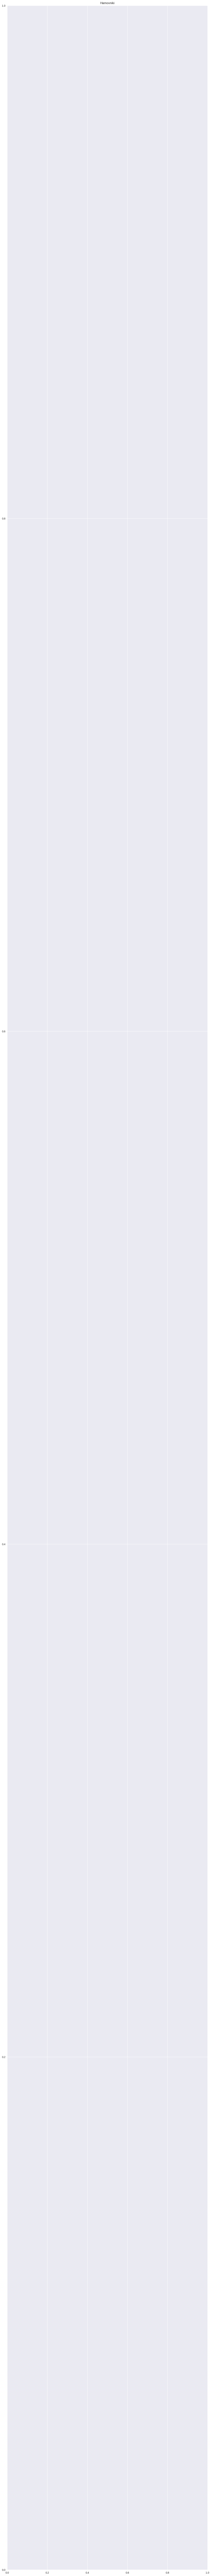

In [303]:
ii, f = 1, plt.figure(figsize=(14,180))
for ir in rajons.rajon[0:30] :
    #print(ir)
    xtrain = train[train['sub_area']==ir].usdm2life
    ytrain = xtrain.resample('1d').mean().dropna();
    ytrain = ytrain[ytrain<=15000]
    if (len(ytrain)/2)<=1 : continue
        
    #ADF = sm.tsa.adfuller(xtrain.resample('1d').mean().dropna(),maxlag=len(ytrain)/2)
    ADF = sm.tsa.adfuller(ytrain,maxlag=len(ytrain)/2)
    print(ir,ADF[1],len(ytrain)/2)
    freq = 7
    if (len(ytrain)/2<freq) : continue
        
    if False :
        sss=smt.seasonal_decompose(ytrain,freq=freq,model='multiplicative')
        ax1, ii = f.add_subplot(40,3,ii), ii+1
        plt.plot(sss.trend.dropna());
        ax1, ii = f.add_subplot(40,3,ii), ii+1
        plt.plot(sss.seasonal.dropna());
        ax1, ii = f.add_subplot(40,3,ii), ii+1
        plt.plot(sss.resid.dropna());
        #plt.plot(ytrain);
        ADF = sm.tsa.adfuller(pd.Series(sss.resid.dropna()),maxlag=len(ytrain)/2)
    if True :
        mod = smt.SARIMAX(ytrain, trend='c', order=(1, 1, 1))
        sss = mod.fit(); res.__dict__
        
        print(sss.polynomial_trend.shape,sss.polynomial_trend[0:6])

        if False :
            ax1, ii = f.add_subplot(40,3,ii), ii+1
            plt.plot(sss.trend.dropna());
            ax1, ii = f.add_subplot(40,3,ii), ii+1
            plt.plot(sss.seasonal.dropna());
            ax1, ii = f.add_subplot(40,3,ii), ii+1
            plt.plot(sss.resid.dropna());
        #plt.plot(ytrain);
        ADF = sm.tsa.adfuller(pd.Series(sss.resid.dropna()),maxlag=len(ytrain)/2)
    plt.title(ir)
    print('------------',ADF,len(ytrain)/2)
    #print(sss.trend.dropna().head())
#plt.show();
#f

In [45]:
ir=rajons.rajon[9]

((123,), timestamp
2011-08-21     7203.241237
2011-09-11     1479.041064
2011-10-02     4414.314993
2011-10-09     8140.045646
2011-10-16     6596.165666
2011-11-20     5383.620505
2011-12-18     7542.200149
2012-01-15     6380.215256
2012-01-29     7896.110237
2012-02-05     8757.020918
2012-02-12      730.001348
2012-03-11     8341.005931
2012-04-01    10225.289540
2012-04-22     9819.391048
2012-05-13     6660.891475
2012-05-20     9037.471040
2012-06-03      948.369336
2012-06-10     8739.472018
2012-06-24     6467.999264
2012-07-01     9200.978347
2012-07-15     6146.836147
2012-08-05     2004.851741
2012-08-12     9240.583465
2012-08-19     5171.472267
2012-08-26     8775.971390
2012-09-16     9024.054513
2012-09-23     6020.080326
2012-11-11     6919.758081
2012-11-25     8131.697951
2012-12-02     1788.883164
                  ...     
2014-08-17     3120.097547
2014-08-24     5741.694150
2014-08-31     5965.062678
2014-09-07     5525.142414
2014-09-14     3969.195375
2014-09-2

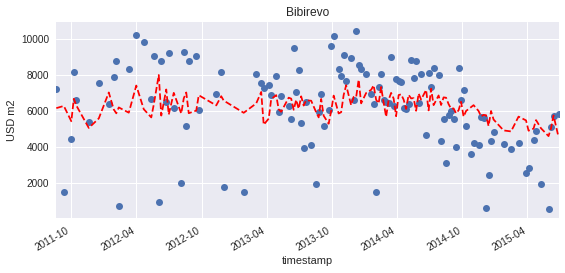

In [46]:
xtrain = train[train['sub_area']==ir].usdm2life
ytrain = xtrain.resample('W').mean().dropna();
ytrain = ytrain[ytrain<=15000]

print(ytrain.shape,ytrain)

mod = smt.SARIMAX(ytrain, trend='c', order=(1, 0, 1),seasonal_order=(1,0,1,4))
res = mod.fit(); #res.__dict__

fig, ax = plt.subplots(figsize=(9,4))
npre = 4
ax.set(title=ir, xlabel='Date', ylabel='USD m2')

# Plot data points
ytrain.plot(ax=ax, style='o', label='Observed')
predict = res.get_prediction()
# Plot predictions
predict.predicted_mean.plot(ax=ax, style='r--', label='ForeCast')
#plt.plot(res.resid[2:]); plt.show()
#tsplot(res.resid[2:], lags=24); plt.show()
fig

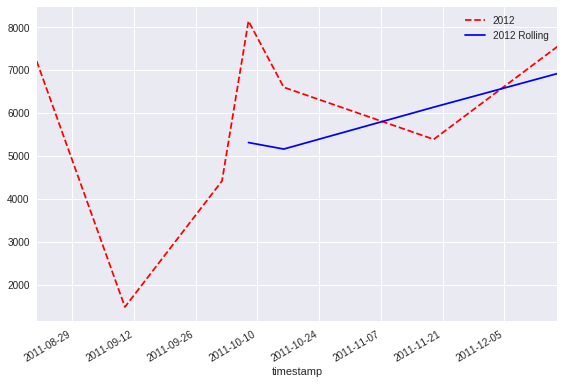

In [58]:
len(ytrain.loc[pd.Timestamp('2014-03-01'):])
ytrain.loc['2015']
ytrain.loc['2011'].resample('2d').mean().dropna()
ytrain.loc['2011'].resample('2d').mean().dropna().plot(label='2012',style='r--'); 
ytrain.loc['2011'].resample('2d').mean().dropna().rolling(4).mean().plot(label='2012 Rolling',style='b-'); 
plt.legend()
plt.tight_layout()
plt.show()

(27274, 405, (-1.1855989977517203, 0.67975977869177151, 7, 397, {'5%': -2.8688478565083417, '1%': -3.4469295619737665, '10%': -2.570662885558566}, 5552.0608035494633))
(27274, 405, (-13.45632210910405, 3.6014141197412366e-25, 7, 391, {'5%': -2.8689604361829928, '1%': -3.4471856790801514, '10%': -2.5707229006220524}, 5170.2518675917809))


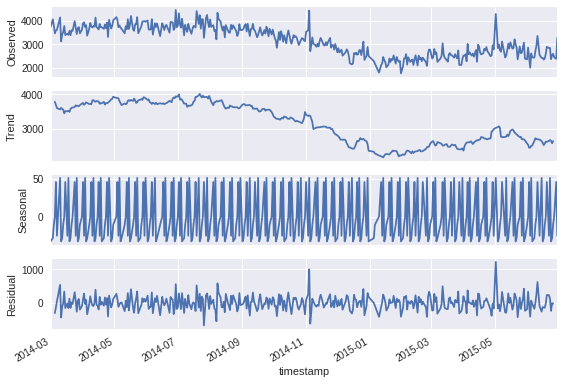

In [69]:
iin = pd.cut(ttrain[ttrain['usdm2full']<5000].usdm2full, 50)
iin[:5]
pd.value_counts(iin)
xtrain=ttrain[(ttrain['usdm2full']<6000) & (ttrain['usdm2full']>1000) ].usdm2full
ytrain=xtrain.loc[pd.Timestamp('2014-03-01'):].resample('1d').mean().dropna(); 
ADF = sm.tsa.adfuller(ytrain,maxlag=7); 
print(len(xtrain),len(ytrain),ADF)

plt.figure(figsize=(14,10))
#smt.seasonal_decompose(ytrain,freq=7,model='multiplicative').plot()
sss=smt.seasonal_decompose(ytrain,freq=7,model='addicative')
ADF = sm.tsa.adfuller(sss.resid.dropna(),maxlag=7); 
print(len(xtrain),len(ytrain),ADF)
sss.plot()
plt.show()

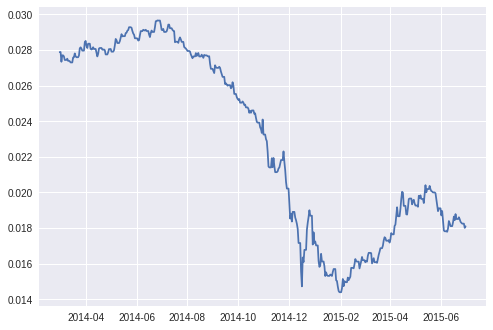

In [73]:
mtrain=1/macro.usdrub.loc[pd.Timestamp('2014-03-01'):pd.Timestamp('2015-06-30')]
plt.plot(mtrain); plt.show()

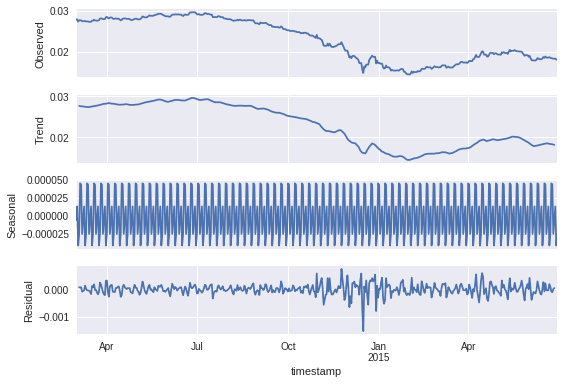

In [74]:
mmm=smt.seasonal_decompose(mtrain,freq=7,model='addicative')
mmm.plot()
plt.show()

In [12]:
corr = macro.corr()
corr[abs(corr)>0.5]

,oil_urals,gdp_quart,gdp_quart_growth,cpi,ppi,gdp_deflator,balance_trade,balance_trade_growth,usdrub,eurrub,...,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm
oil_urals,1.000000,NaN,0.723601,-0.730893,-0.567825,-0.831245,0.756507,NaN,-0.896539,-0.870997,...,-0.938380,NaN,0.737900,NaN,0.810437,-0.828357,NaN,NaN,NaN,-0.582655
gdp_quart,NaN,1.000000,-0.730279,0.831981,0.870779,0.854641,NaN,NaN,0.711289,0.730896,...,-0.830439,0.919949,0.914008,0.654632,0.899688,0.827409,0.791715,0.777215,0.851396,NaN
gdp_quart_growth,0.723601,-0.730279,1.000000,-0.900038,-0.866393,-0.850159,NaN,NaN,-0.838880,-0.836105,...,NaN,-0.797920,-0.624391,NaN,-0.622531,-0.885556,-0.890549,-0.826483,-0.669109,NaN
cpi,-0.730893,0.831981,-0.900038,1.000000,0.966001,0.954043,-0.541112,NaN,0.918335,0.916164,...,-0.931070,0.918267,0.961128,0.622652,0.952960,0.969202,0.937238,0.902425,0.853122,NaN
ppi,-0.567825,0.870779,-0.866393,0.966001,1.000000,0.936734,NaN,NaN,0.822143,0.820750,...,-0.911639,0.926775,0.930183,0.740442,0.939415,0.928301,0.847339,0.758269,0.851333,NaN
gdp_deflator,-0.831245,0.854641,-0.850159,0.954043,0.936734,1.000000,-0.624249,NaN,0.861502,0.854419,...,NaN,0.988902,0.999996,NaN,0.952380,0.942390,0.924476,0.939339,0.936640,NaN
balance_trade,0.756507,NaN,NaN,-0.541112,NaN,-0.624249,1.000000,NaN,-0.663685,-0.641430,...,-0.654460,NaN,NaN,NaN,0.528931,NaN,NaN,NaN,NaN,NaN
balance_trade_growth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,...,-0.733588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
usdrub,-0.896539,0.711289,-0.838880,0.918335,0.822143,0.861502,-0.663685,NaN,1.000000,0.990832,...,NaN,0.685330,NaN,NaN,NaN,0.868944,0.611508,0.546962,NaN,0.577564
eurrub,-0.870997,0.730896,-0.836105,0.916164,0.820750,0.854419,-0.641430,NaN,0.990832,1.000000,...,NaN,0.699566,NaN,NaN,NaN,0.875554,0.655819,NaN,NaN,0.506566


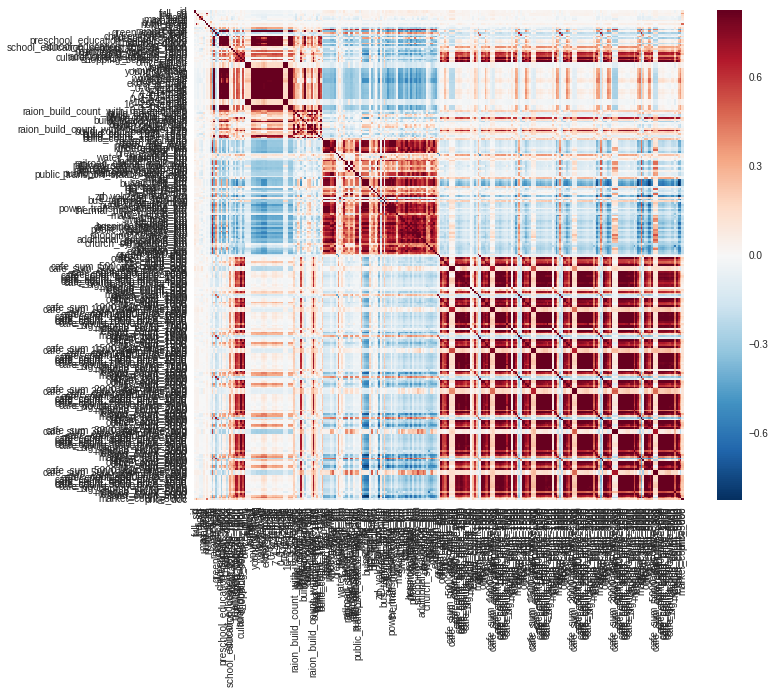

In [47]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(corr, vmax=.8, square=True); f

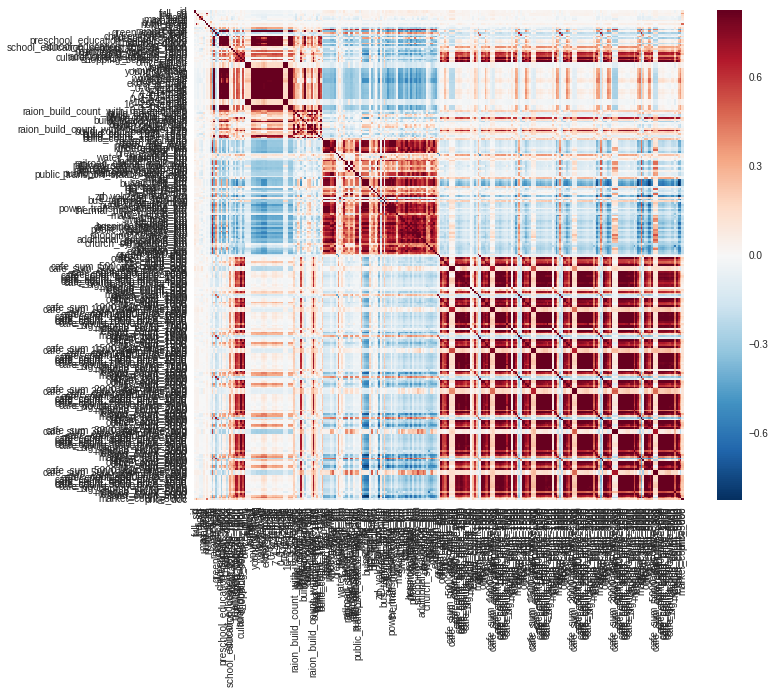

In [48]:
corr = train.corr()
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(corr, vmax=.8, square=True); f

In [81]:
## HW (Holt-Winters) exponent smoothing (1 - trend, 2 - (trend+level), 3 - (trend+level+season))
def exp1_smooth ( series, alpha) :
    result = [series[0]]
    for i in range(1,len(series)) :
        result.append(alpha*series[i]+(1.0-alpha)*result[-1])
    return(result)

def exp2_smooth ( series, alpha, beta) :
    level, trend = series[0], series[1]-series[0]
    result = [series[0],level+trend]
    for i in range(2,len(series)) :
        last_level, last_trend = level, trend
        level = alpha*series[i]+(1-alpha)*(last_level+last_trend)
        trend = beta * (level-last_level) + (1-beta) * last_trend;
        result.append(level+trend)
    return(result)

def exp3_smooth ( series, alpha, beta, gamma, l) :
    
    return(result)

class HoltWinters:

    """
    Взято из : https://habrahabr.ru/company/ods/blog/327242/
    
    Модель Хольта-Винтерса с методом Брутлага для детектирования аномалий
    https://fedcsis.org/proceedings/2012/pliks/118.pdf

    # series - исходный временной ряд
    # slen - длина сезона
    # alpha, beta, gamma - коэффициенты модели Хольта-Винтерса
    # n_preds - горизонт предсказаний
    # scaling_factor - задаёт ширину доверительного интервала по Брутлагу (обычно принимает значения от 2 до 3)

    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series)+self.n_preds):
            if i == 0: # инициализируем значения компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                continue
            if i >= len(self.series): # прогнозируем
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])

                # во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 

            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])

                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])

            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

In [82]:
%%time
alpha = 0.2
beta  = 0.5
es1 = exp1_smooth(train['price_doc'],alpha)
es2 = exp2_smooth(train['price_doc'],alpha,beta)

CPU times: user 660 ms, sys: 56 ms, total: 716 ms
Wall time: 595 ms


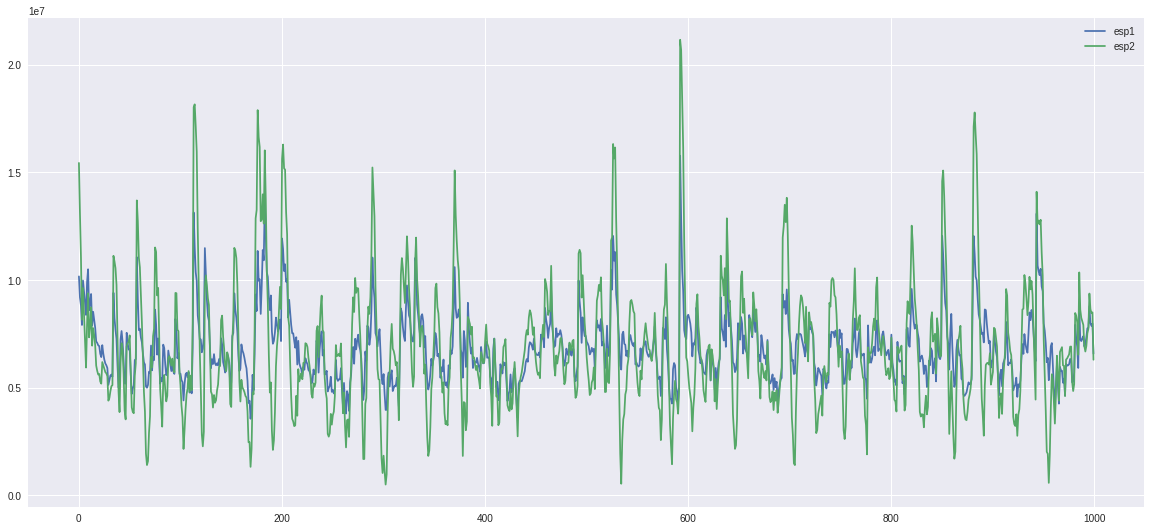

In [79]:
#plt.clear()
f = plt.figure(figsize=(20, 9)); legenda = [];
#plt.plot(train['price_doc'][1000:2000].tolist()); legenda = ['price']
plt.plot(es1[1000:2000]); legenda = legenda + ['esp1']
plt.plot(es2[1000:2000]); legenda = legenda + ['esp2']

plt.legend(legenda)

plt.show()

In [86]:
import xgboost as xgb